In [1]:
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import SGD, Adam
from torchsummary import summary
from torch import optim

In [2]:
data_folder = '~/data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

In [3]:
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [4]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        x = x.float()/255
        x = x.view(-1,1,28,28) 
        self.x, self.y = x, y
    def __getitem__(self, index):
        x, y = self.x[index], self.y[index]
        return x, y
    def __len__(self):
        return len(self.x)

##### CNN Model Architecture

In [5]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1,64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [6]:
# Define a function for training and validating the batch
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()


@torch.no_grad
def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.tolist()

@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    loss_fn = nn.CrossEntropyLoss()
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

# Fetch the data
def get_data():
    train = MyDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = MyDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl


In [7]:
# Check the model's summary
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

In [8]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# let the training begin
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.append(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


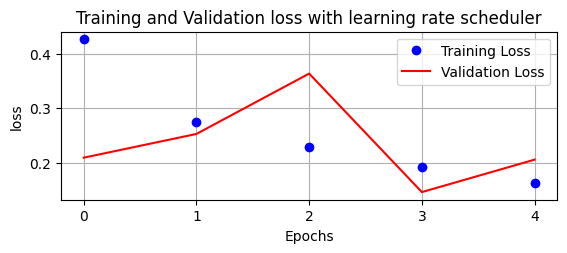

/var/folders/y5/5kc5fqvn2tncnl_868zg4zhr0000gn/T/ipykernel_63266/4124558816.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


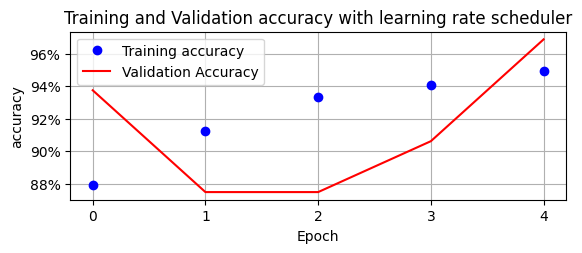

In [9]:
import matplotlib.ticker as mtick
epochs = np.arange(5)
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label="Validation Loss")
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.legend()
plt.title("Training and Validation loss with learning rate scheduler")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label="Training accuracy")
plt.plot(epochs, val_accuracies, 'r', label="Validation Accuracy")
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.title("Training and Validation accuracy with learning rate scheduler")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()
